# Universe creation and manipulation

Using MDAnalysis, RDKit, and OpenMM we will create an alpha helix from a sequence of amino acids. There are better tools to do that specific task, but it will make us use various interesting features of MDAnalysis.

In [1]:
import MDAnalysis as mda
import nglview as nv

_ColormakerRegistry()

In [2]:
from simtk import openmm, unit
from simtk.openmm import app
import pdbfixer

In [3]:
import rdkit

In [4]:
import numpy as np

## Creating a topology from a sequence using RDKit

RDKit can create a peptide from a sequence using [`MolFromSequence`](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolFromSequence). Create an RDKit molecule for the [WALP peptide](https://en.wikipedia.org/wiki/WALP_peptide) with the sequence GWWLALALALALALALWWA.

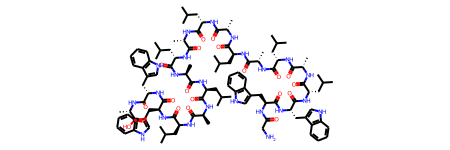

In [5]:
peptide = rdkit.Chem.MolFromSequence('GWWLALALALALALALWWA')
peptide

Our peptide has a tolopogy but no coordinates. Ideally, we would create 3D coordinates using [`AllChem.EmbedMolecule`](https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html?highlight=embedmolecule#rdkit.Chem.rdDistGeom.EmbedMolecule), sadly the method fails with our molecule. Instead, generate 2D coordinates using [`Compute2DCoords`](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html?highlight=compute2dcoord#rdkit.Chem.rdchem.Mol.Compute2DCoords).

In [6]:
peptide.Compute2DCoords()

0

## Fix the backbone with MDAnalysis

At this point we have the correct topology, but the coordinates of the atoms are completely wrong. We will first fold the backbone into an helix using MDAnalysis, then we will fix the side chains using OpenMM.

### Loading the structure in MDAnalysis

MDAnalysis tries to be interoperable with as many tools as possible. Since version 2.0.0, it is possible to create a universe from an RDKit molecule, and vice versa.

Create a universe `u` from our RDKit peptide, then visualise the universe using NGLview.

In [7]:
u = mda.Universe(peptide)

In [8]:
v = nv.show_mdanalysis(u)
v.add_ball_and_stick()
v

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:749: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'
  "".format(attrname, default))


NGLWidget()

### Finding the phi angles

To create an alpha helix, we need to set the phi, psi, and omega dihedral angles to -60°, -50°, and 180°, respectivelly. The phi angle for a given residue is defined by the atoms `C` of the previous residue, `N`, `CA`, and `C`. The psi angle is defined by the atoms `N`, `C`, `CA`, and `N` from the next residue. Omega is defined by atoms `CA` and `C` of the previous residue, `N`, and `CA`.

Before we can set the dihedral angles, we need to find them and get their current values. For each residue, create an atom group containing the 4 defining atoms of the phi angle.

In [9]:
u.residues.phi_selections()

[None,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>,
 <AtomGroup with 4 atoms>]

Calculate the angle in degrees for each phi angle.

In [10]:
[ag.dihedral.value() for ag in u.residues.phi_selections() if ag is not None]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.0,
 -180.0,
 0.0,
 0.0,
 0.0,
 180.0,
 180.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

### Rotating around a bond



### Building the helix

In [11]:
def set_dihedrals(ag, target_dihedral, dihedral_name):
    all_atoms = ag.universe.atoms
    
    for residue in ag.residues:
        if dihedral_name == 'phi':
            dihedral_selection = residue.phi_selection()
        elif dihedral_name == 'psi':
            dihedral_selection = residue.psi_selection()
        elif dihedral_name == 'omega':
            dihedral_selection = residue.omega_selection()
        else:
            raise ValueError(f'dihedral_name cannot be "{dihedral_name}"')

        if dihedral_selection is None:
            continue

        central_bond = dihedral_selection.intra_bonds[1]
        bond_vector = central_bond.atoms[1].position - central_bond.atoms[0].position
        center = central_bond.atoms[1].position

        mobile = all_atoms[central_bond.atoms[1].ix:] & ag
        
        dihedral = dihedral_selection.dihedral.value()
        dihedral_delta = target_dihedral - dihedral

        mobile.rotateby(dihedral_delta, bond_vector, center)

In [12]:
set_dihedrals(u.atoms, -60, 'phi')

In [13]:
set_dihedrals(u.atoms, -50, 'psi')

In [14]:
set_dihedrals(u.atoms, 180, 'omega')

In [15]:
v = nv.show_mdanalysis(u)
v.add_ball_and_stick()
v

NGLWidget()

## Fix the side chains with OpenMM

The backbone of the peptide is folded as an helix. However the side chains are completely unphysical. To fix this we will use OpenMM to minimize the energy of the system. This requires to setup a simulation system so, first, we will have to add the hydrogen atoms.

### Setting a box size

We will be able to set the box when builing the OpenMM system. But this is an MDAnalysis workshop so let's do it with MDAnalysis!

What is the current box size?

In [40]:
u.dimensions

array([100., 100., 100.,  90.,  90.,  90.], dtype=float32)

The `dimension` array contains the length of the box vectors and the box vector angles.

We will use an implicit solvent to minimise the energy of our peptide, we could also have done it in vacuum, this means the size of the box does not matter much as long as it is large enough for the peptide not to interact with its periodic image. Set the box for this universe to be cubic with 10 nm sides.

In [16]:
u.dimensions = [100, 100, 100, 90, 90, 90]

### Adding the hydrogen atoms

Our peptide does not have any hydrogen atoms. We could have added them earlier with RDKit; instead we will add them using [pdbfixer](https://github.com/openmm/pdbfixer), a tool related to OpenMM.

Sadly, we cannot create an OpenMM topology from MDAnalysis, yet. To pass our system from MDAnalysis to OpenMM write it as a PDB file named `walp_broken.pdb`.

In [17]:
u.atoms.write('walp_broken.pdb')

Now, we can load the PDB in pdbfixer and add the hydrogen atoms. Here is the code to do so.

In [18]:
u.atoms.write('walp_broken.pdb')

In [19]:
# Load the PDB file we just created
fixer = pdbfixer.PDBFixer('walp_broken.pdb')
# The PDBFixer object first need to find what is missing
# in the structure and we need to request it explicitly
# to do so.
fixer.findMissingResidues()
fixer.findMissingAtoms()
# Finally! We can add the hydrogen atoms, both in the
# topology and the structure.
fixer.addMissingHydrogens()

### Loading the structure with hydrogen atoms in MDAnalysis

MDAnalysis can create a Universe from various OpenMM object including [`Topology`](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.topology.Topology.html), [`PDBFile`](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.pdbfile.PDBFile.html#), [`PDBxFile`](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.pdbxfile.PDBxFile.html#), [`Modeller`](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.modeller.Modeller.html#), and [`Simulation`](http://docs.openmm.org/7.0.0/api-python/generated/simtk.openmm.app.simulation.Simulation.html#). It cannot, however, create a Universe from a PDBFixer object. Though, we can create a Universe from an array of coordinate and the topology in the PDBFixer object!

The coordinates of the atoms are accessible as `fixer.positions`. Create an numpy array of these positions. Be carefull that pdbfixer uses nanometers by default, while MDAnalysis works in ångströms.

In [22]:
position_array = np.array(fixer.positions.value_in_unit(unit.angstrom))

Now, create an MDAnalysis's Universe from the `fixer.topology` and the array of coordinates you just created. The topology in a PDBFixer object is not exactly an OpenMM topology (it does not use the same python class), but it uses the same interface making it compatible. Because it is not the same class as an OpenMM topology, MDAnalysis does not automatically recognise how to read it; use `topology_format='OPENMMTOPOLOGY'` to specify a topology parser.

In [23]:
u_hydrogen = mda.Universe(fixer.topology, position_array, topology_format='OPENMMTOPOLOGY')

Visualise the new universe. Does it contain hydrogen atoms?

In [39]:
v = nv.show_mdanalysis(u_hydrogen)
v.add_ball_and_stick()
v

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:749: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))
c:\users\dr19502\dev\mdan

NGLWidget()

### Buiding the simulation for the energy minimisation

Everything is finally ready to setup OpenMM. We will use the Amber10 force field and an implicit solvent.

In [25]:
forcefield = app.ForceField('amber10.xml', 'amber10_obc.xml')
system = forcefield.createSystem(fixer.topology)
# We do not need an integrator, but OpenMM will not create a
# simulation system without one.
integrator = openmm.LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtosecond)

We spent some time folding the backbone, we do not want the energy minimisation to alter it. We will apply position restraints on the "N", "C", and "CA" atoms of the backbone.

In [ ]:
force = openmm.CustomExternalForce('k * periodicdistance(x, y, z, x0, y0, z0)^2')
force.addGlobalParameter('k', 1e5 * unit.kilocalorie_per_mole / unit.nanometer ** 2)
force.addPerParticleParameter('x0')
force.addPerParticleParameter('y0')
force.addPerParticleParameter('z0')
system.addForce(force)

We need to tell OpenMM to which atoms to apply the position restraints. We will use MDAnalysis to identify these atoms.

Create an AtomGroup containing the "N", "CA", and "C" atoms of the peptide bachbone from the universe with hydrogen atoms we built earlier.

In [24]:
backbone = u_hydrogen.select_atoms('name N CA C')

Adding the a particle to the pool of position restraints is done with the `force.addParticle` method. The first argument to that method is the index of the atom in the overall structure (starting from 0), the second argument is a list of the x, y, and z coordinate for the atom in nanometers.

Add the backbone atoms we just selected to the position restraints.

In [26]:
for atom in backbone:
    position = [pos / 10 for pos in atom.position]
    force.addParticle(int(atom.ix), position)

Now we can run the energy minimisation.

In [29]:
# Create the simulation object
simulation = app.Simulation(fixer.topology, system, integrator)
# Set the position for each atom
simulation.context.setPositions(fixer.positions)
# Finally minimise the energy of the system
simulation.minimizeEnergy()

## Check the final backbone with MDAnalysis

We have a final structure. Load it into MDAnalysis and visualise it with NGLview.

In [33]:
minimized = mda.Universe(simulation)

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\base.py:873: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [34]:
v = nv.show_mdanalysis(minimized)
v.add_ball_and_stick()
v

c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
c:\users\dr19502\dev\mdanalysis\package\MDAnalysis\coordinates\PDB.py:1083: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget()

Finally, check that the dihedral angles are the ones we expect: -60°, -50°, and 180° for the phi, psi and omega angles, respectively.

In [35]:
[ag.dihedral.value() for ag in minimized.residues.phi_selections() if ag is not None]

[-58.731304305097176,
 -60.716517905509896,
 -59.344718452294956,
 -59.43819952075698,
 -60.920408237287454,
 -58.6708707943974,
 -59.37355658478379,
 -58.82387486378292,
 -60.91455791791515,
 -58.397680766208694,
 -59.623766573927085,
 -59.062266032331415,
 -60.951968246144155,
 -58.48341057446834,
 -62.71307847889898,
 -59.87707849141786,
 -61.79326803881186,
 -60.75273031729227]

In [36]:
[ag.dihedral.value() for ag in minimized.residues.psi_selections() if ag is not None]

[-51.82677333512887,
 -52.05261139532773,
 -49.46989927526103,
 -54.69320050670237,
 -50.56727284191701,
 -53.78470245384232,
 -50.82360949138108,
 -54.36635575188945,
 -50.68885203085368,
 -53.66354020016331,
 -50.799057683786984,
 -54.3358613992427,
 -50.1549352563543,
 -53.71607062873572,
 -50.559985545694424,
 -50.79641941861376,
 -49.26687513189845,
 -50.15391653980088]

In [37]:
[ag.dihedral.value() for ag in minimized.residues.omega_selections() if ag is not None]

[-178.81415803013851,
 -178.9114944870656,
 -179.42329189039694,
 -177.9122622107268,
 -178.43510838153966,
 -177.8453877866217,
 -179.07395694003256,
 -178.04079289908984,
 -178.7577136173959,
 -178.00418031779256,
 -179.12057794610078,
 -177.94725336189208,
 -179.17182676301772,
 -177.9395967712022,
 -178.59145182328385,
 -179.1509215021304,
 -179.88706111485502,
 -179.41296715225764]

## Going further

* Progressively relax the position restraints on the backbone during the energy minimisation. We used very strong position restraints on the backbone when minimising the energy of the peptide. This is needed because the unphysical structure yields very high energies. As the side chain are better placed after the first round of energy minimisation, it should be possible to run subsequent energy minimisation steps with weaker position restraints to obtain a more realistic backbone.
* Insert the peptide in a lipid bilayer. The peptide we built is called WALP, it is an artificial peptide that have been designed to study how protein behave in lipid bilayers. Get a lipid bilayer from the [NMRlipids project](https://github.com/NMRLipids/Databank), insert the peptide perpendicular to the lipid bilayer, and remove the lipid and solvent molecules that overlap with the peptide.